$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# ACISDetector On Raw Binaries
<a id=ACISDetector></a>
In this part, we will examine our algorithms to classify binaries. Additionally, we'll write training loops and implement a modular model trainer. We'll use a few configurations for classifying architecture and instruction set with [isadetect]( https://github.com/kairis/isadetect) Raw Binaries Datasets.


In [2]:
import os
import re
import sys
import glob
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Architecture and instruction set
<a id=arch_is></a>
<!--isadetect 

@inproceedings{kairajarvi2020isadetect,
author={Kairaj\"arvi, Sami and Costin, Andrei and H\"am\"al\"ainen, Timo},
title={{ISAdetect: Usable Automated Detection of CPU Architecture and Endianness for Executable Binary Files and Object Code}},
booktitle={Proceedings of the Tenth ACM Conference on Data and Application Security and Privacy},
year={2020},
url="https://doi.org/10.1145/3374664.3375742"
}
-->

In this section, we want to try another approche to idintify architecture

In [4]:
import isadetect.helpers as isa_api 
import src.arch_classifier as arch_api
import src.hyperparams as hp
from src.binary_dataset import FeatureDataset,DatasetToTuple
import src.arch_trainer as training


## Preprocessing 
We recommend to download this [dataset](https://etsin.fairdata.fi/api/dl?cr_id=9f6203f5-2360-426f-b9df-052f3f936ed2&file_id=5e22279a495dd868433305f34471026) before you run this block. 
After the dataset has been downloaded, place it on: '.pytorch-datasets' folder in your home folder

In [9]:
import pathlib
import tarfile
import urllib
import shutil
DOWNLOAD_URL = 'https://etsin.fairdata.fi/api/dl?cr_id=9f6203f5-2360-426f-b9df-052f3f936ed2&file_id=5e22279a495dd868433305f34471026'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_dataset(out_path=DATA_DIR, url=DOWNLOAD_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, "isa_full_binaries")
    tar_out_filename= out_filename + ".tar.gz
    
    if os.path.isfile(tar_out_filename) and not force:
        print(f'Dataset file {tar_out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(tar_out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {tar_out_filename}.')
    
    if os.path.isdir(out_filename) and not force:
        print(f'Dataset dir {out_filename} exists, skipping extraction.')
    else:
        tf = tarfile.open(tar_out_filename)
        tf.extractall()
        
    return out_filename

DATASET_FILE = download_dataset()



KeyboardInterrupt: 

In [17]:
binary_dataset = FeatureDataset(DATASET_FILE)
N = len(binary_dataset)
batch_size = 32
print(f'features length: {N}')

train_length = int(0.7* N)
test_length = N - train_length
ds_train,ds_test = torch.utils.data.random_split(binary_dataset,(train_length,test_length))

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

dl_train = torch.utils.data.DataLoader(ds_train,batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size, shuffle=True)

x0,y0 = ds_train[0]
dataset_shape = (x0.shape if x0.dim() > 0 else 1),(y0.shape if y0.dim() > 0 else 1)
print('input size =', dataset_shape[0], "X",dataset_shape[1] )

features length: 581
Train: 406 samples
Test: 175 samples
input size = torch.Size([293]) X 1


Now after we downloaded the ELF binary dataset, we want to make two types of datasets:
- **Channeled Dataset** - We would like to treat the ELF as if it were an image. Where each section from the ELF files is a dimension of the image
- **Blob Matrix Dataset** - Each section will split to Rows, each row is 16 (0xF) bytes.
- **Long String Dataset** - We will treat our information as if it were one long text, so we will use work methodologies like NLP


#### Channeled Dataset

#### Blob Matrix Dataset

#### Long String Dataset

## Training
<a id=part2_3></a>

in order to plot our result and to compare them, we will use plot.py
and then we'll use the following function to load multiple experiment results and plot them together.

In [6]:
from jupyter_utils.plot import plot_fit, plot_exp_results
fig = None
fit_res = []

num_classes = 24
in_size = dataset_shape[0][0]
help(plot_fit)

NameError: name 'dataset_shape' is not defined

In [83]:
mlp_hp = hp.mlp_hp()
print(mlp_hp)

_mlp = arch_api.MLP(in_size,num_classes,mlp_hp['hidden_size'])
optimizer = torch.optim.SGD(_mlp.parameters(), lr=mlp_hp['lr'], weight_decay=mlp_hp['reg'])
loss_fn = torch.nn.CrossEntropyLoss()
trainer = training.ArchTrainer(_mlp, loss_fn, optimizer, device)
print(_mlp)
fit_res.append({"legend":"MLP","result":trainer.fit(dl_train,dl_test,num_epochs = 10,print_every=100)})

{'hidden_size': [512, 1024, 256], 'lr': 0.01, 'reg': 0.05}
MLP(
  (classifier): Sequential(
    (0): Linear(in_features=293, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=24, bias=True)
    (7): Softmax(dim=1)
  )
)
--- EPOCH 1/10 ---
test_batch (Avg. Loss 3.177, Accuracy 0.0): 100%|█████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.52it/s]
--- EPOCH 10/10 ---
test_batch (Avg. Loss 3.174, Accuracy 100.0): 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 117.71it/s]


In [ ]:
cnn_hp = hp.cnn_hp()
print(cnn_hp)

#_cnn = arch_ap i.CNN()
#print(_cnn)

#fit_res.insert(trainer(_cnn))


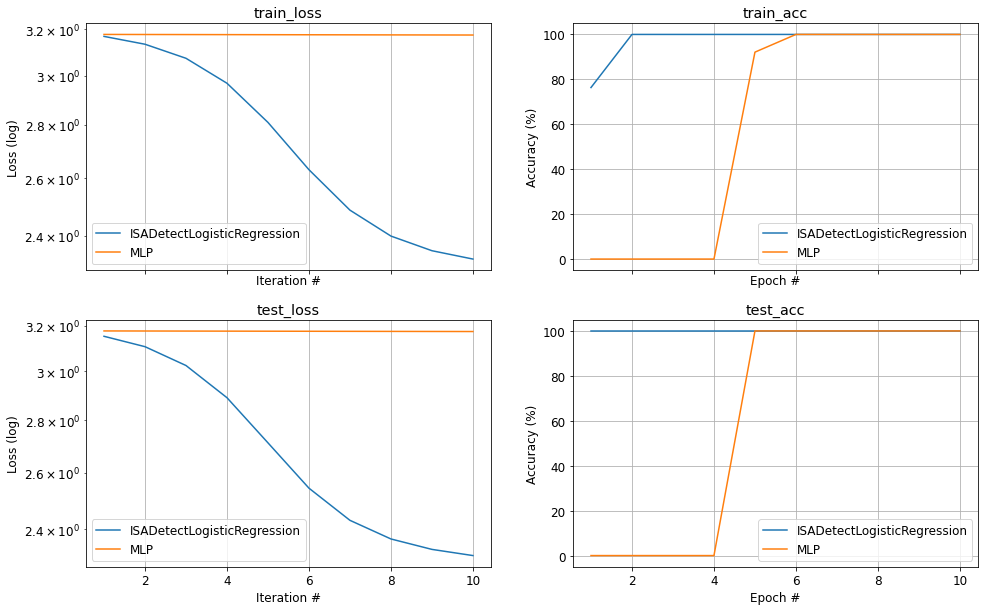

In [84]:
for elem in fit_res:
    fig, axes = plot_fit(elem['result'], fig, legend = elem['legend'],log_loss=True)
fig = []

In [ ]:
rnn_hp = hp.rnn_hp()
print(rnn_hp)
